In [2]:
import pandas as pd
import numpy as np 
import csv
import matplotlib.pyplot as plt
import math
from pandas_datareader import data
import scipy.optimize
from scipy import stats
import scipy.integrate
import scipy.special
from statsmodels.tsa import stattools
from statsmodels.tsa import arima_model
from statsmodels.graphics import gofplots
from statsmodels.regression import linear_model

In [3]:
#read tickers from csv file
tickers_file = 'TechTickers.csv'
tickers = [];
f = open(tickers_file, "r", encoding='utf-8-sig')
for line in csv.reader(f):
    tickers.append(str(line[0]))
f.close
#print(tickers)

<function TextIOWrapper.close()>

In [4]:
#download price data from Yahoo
start_date = '2009-01-01'
end_date = '2019-12-31'
stock_data = data.get_data_yahoo(tickers, start_date, end_date)

In [5]:
#create a list of tickers whose adjusted closing prices in the first month of the first year
#do not have any missing values
stockArray = []
for ticker in tickers:
    stockArray.append(list(stock_data['Adj Close'][ticker]))
stockArray=np.array(stockArray)
tickers_liq = []
for i in range(len(tickers)):
    temp=0
    for j in range(len(stockArray[i,:])):
        if math.isnan(stockArray[i,j]):
            temp=1
    if (temp==0):
        tickers_liq.append(tickers[i])
print(tickers_liq)

['AAPL', 'MSFT', 'TSM', 'INTC', 'CSCO', 'ORCL', 'SAP', 'ADBE', 'CRM', 'NVDA', 'ACN', 'ASML', 'TXN', 'IBM', 'QCOM', 'FIS', 'SNE', 'INTU', 'MU', 'VMW', 'AMAT', 'AMD', 'ADI', 'LRCX', 'INFY', 'ADSK', 'CTSH', 'TEL', 'APH', 'HPQ']


In [6]:
#save the list of tickers without any initial missing values
tickers = list(tickers_liq) #use "list" when assigning a list to a new list in case mistakes
np.savetxt("TechTickers_liq.csv",np.array(tickers),fmt='%1s',delimiter=',')

In [7]:
#for the given range of years, download and save all adjusted closing prices for the tickers
#from the list of those without missing initial values
stockArray = []
for ticker in tickers_liq:
    stockArray.append(list(stock_data['Adj Close'][ticker]))
stockArray=np.array(stockArray)
np.savetxt("AdjustedClosingPrices_2009To2019.csv",np.transpose(stockArray),delimiter=',')

In [16]:
#some initialization

# d = np.shape(stockArray)[0]
d = 2

AdjPrice_file = "AdjustedClosingPrices_2009To2019.csv"
f = open(AdjPrice_file,"r",encoding='utf-8-sig')
AdjPrice = pd.read_csv('AdjustedClosingPrices_2009To2019.csv', header=None)
AdjPrice = np.array(AdjPrice)

#calibrition settings
N = 100 #estimation window size
T_bar = 40 #max holding time
T = 30 #upper bound time for computing expd tau
p_star = 0.05 #significant level for DF test
T_lam = 0 #transaction cost
lambda_bar = 3 #stop-loss lower bound
C_bar = 1000000 #investment money on long side

In [17]:
def expd_tau(lmbd, _rho, _sigma): 
    #expected input: lmbd -- list of length 2, lmbd[0]<=lmbd[1], _rho, _sigma -- positive scalar parameters    
    result = scipy.integrate.quad(lambda x: math.exp((x**2)*_rho/(_sigma**2))*(1+scipy.special.erf(x*(_rho**0.5)/_sigma)), lmbd[0], lmbd[1])
    return result[0]*(np.pi**0.5)/(_sigma*(_rho**0.5))

In [18]:
#this is not necessary, I just want to check the progress and ignore warnings
from __future__ import division
 
import sys,time
from progressbar import *
total = 1000

# progress = ProgressBar()
# for i in progress(range(total)):
#   time.sleep(0.01)

import warnings

warnings.filterwarnings('ignore')

In [19]:
#1(a) invest with C_bar
lambda2 = np.zeros((d,d)) #lam2* for pair i,j
ifopen = np.zeros((d,d)) #if open the position
iflong = np.zeros((d,d)) #if long the pair
P_matrix = np.zeros((d,d)) #for computing shares
c_matrix = np.zeros((d,d)) #coeff matrix for pair i,j
mean_matrix = np.zeros((d,d)) #mean of process for pairs
sigma_tilde_matrix = np.zeros((d,d)) #for stop-loss mech
open_time_matrix = np.zeros((d,d)) #for stop-loss mech
port1 = np.zeros((len(AdjPrice[:,0]),d)) #num of shares with time and asset

pbar = ProgressBar().start()
for k in range(len(AdjPrice[:,0])-N):
    pbar.update(int((k/(len(AdjPrice[:,0])-N-1))*100))
    time.sleep(0.01)
#we are standing at day k+N actually
    port1[k+N,:] = port1[k+N-1,:]
    for i in range(d):
        for j in range(i+1,d):
            
            #not open, tell if should open
            if ifopen[i,j] == 0:
                Calibri_Pri_i = AdjPrice[k:k+N,i]
                Calibri_Pri_j = AdjPrice[k:k+N,j]
                
                #regression
                my_arima = arima_model.ARMA(Calibri_Pri_i,[1,0],Calibri_Pri_j)
                arma_results = my_arima.fit()
                c_ij = arma_results.params[1]
                
                #construct the pair
                Z = np.array(Calibri_Pri_i)-np.array(Calibri_Pri_j)*c_ij
                mean_Z = np.mean(Z)
                Z = Z-np.mean(Z)
                
                #run DF test
                my_DF = stattools.adfuller(Z,1,'c',None)
                
                #if cointegrated, open position
                if my_DF[1] <= p_star:
                    ifopen[i,j] = 1
                    open_time_matrix[i,j] = k+N
                    c_matrix[i,j] = c_ij
                    mean_matrix[i,j] = mean_Z
                    phi, sigma = linear_model.yule_walker(Z, order=1)
                    rho = 1-phi[0]
                    
                    sigma_tilde = sigma/((1-phi[0]**2)**0.5)
                    sigma_tilde_matrix[i,j] = sigma_tilde
                    
                    lambda1 = AdjPrice[k+N,i]-AdjPrice[k+N,j]*c_ij-mean_Z
                    P = AdjPrice[k+N,i]
                    P_matrix[i,j] = P
                    c = P*4*T_lam
                    
                    if lambda1 <= 0:
                        iflong[i,j] = 1
                        port1[k+N,i] += C_bar / P
                        port1[k+N,j] += C_bar / P * (-c_ij)
                        obj = lambda lam: -(lam-lambda1-c)*(T-expd_tau([lambda1,lam],rho,sigma))/P
                        cons = ({'type': 'ineq', 'fun': lambda lmbd: lmbd-lambda1-c},
                               {'type': 'ineq', 'fun': lambda lmbd: T-expd_tau([lambda1,lmbd],rho,sigma)}) # inequality means that it is to be non-negative
                        lmbd0 = lambda1/2
                        opt = scipy.optimize.minimize(obj,lmbd0,constraints=cons)
                        lambda2[i,j] = opt.x[0]
                    else:
                        iflong[i,j] = 0
                        port1[k+N,i] += -C_bar / P
                        port1[k+N,j] += C_bar / P * c_ij
                        obj = lambda lam: -(lambda1-lam-c)*(T-expd_tau([-lambda1,-lam],rho,sigma))/P
                        cons = ({'type': 'ineq', 'fun': lambda lmbd: lambda1-lmbd-c},
                               {'type': 'ineq', 'fun': lambda lmbd: T-expd_tau([-lambda1,-lmbd],rho,sigma)}) # inequality means that it is to be non-negative
                        lmbd0 = lambda1/2
                        opt = scipy.optimize.minimize(obj,lmbd0,constraints=cons)
                        lambda2[i,j] = opt.x[0]
                        
            #already open, tell if close            
            elif ifopen[i,j] == 1:
                #tell if we should close
                if iflong[i,j] == 1:
                    if AdjPrice[k+N,i]-c_matrix[i,j]*AdjPrice[k+N,j]-mean_matrix[i,j] >= lambda2[i,j] or AdjPrice[k+N,i]-c_matrix[i,j]*AdjPrice[k+N,j]-mean_matrix[i,j] <= -lambda_bar*sigma_tilde_matrix[i,j] or k + N - open_time_matrix[i,j] > T_bar:
                        ifopen[i,j] = 0
                        port1[k+N,i] -= C_bar / P_matrix[i,j]
                        port1[k+N,j] -= C_bar / P_matrix[i,j] * (-c_matrix[i,j])
                        
                elif iflong[i,j] == 0:
                    if AdjPrice[k+N,i]-c_matrix[i,j]*AdjPrice[k+N,j]-mean_matrix[i,j] <= lambda2[i,j] or AdjPrice[k+N,i]-c_matrix[i,j]*AdjPrice[k+N,j]-mean_matrix[i,j] >= lambda_bar*sigma_tilde_matrix[i,j] or k + N - open_time_matrix[i,j] > T_bar:
                        ifopen[i,j] = 0
                        port1[k+N,i] -= -C_bar / P_matrix[i,j]
                        port1[k+N,j] -= C_bar / P_matrix[i,j] * c_matrix[i,j]

pbar.finish()

100% |########################################################################|


In [21]:
#1(a) continue
#compute total long and short
Total_Amount = np.multiply(port1,AdjPrice[:,:d])
L1 = np.sum((Total_Amount>0)*Total_Amount,axis=1)
S1 = -np.sum((Total_Amount<0)*Total_Amount,axis=1)

#compute absolute PnL process
abs_PnL1 = []
for i in range(d):
    temp = []
    for k in range(len(AdjPrice[:,0])-N):
        if k == 0:
            temp.append(AdjPrice[k+N-1,i])
        else:
            temp.append(temp[-1]+port1[k+N-1,i]*(AdjPrice[k+N,i]-AdjPrice[k+N-1,i])-np.abs(port1[k+N-1,i]-port1[k+N-2,i])*AdjPrice[k+N-1,i]*T_lam)
    
    abs_PnL1.append(temp)
    
abs_PnL1 = np.sum(abs_PnL1, axis=0)
abs_PnL1 = np.array(abs_PnL1)

#compute relative PnL process
rel_PnL1 = []
for k in range(len(AdjPrice[:,0])-N):
    if k == 0:
        rel_PnL1.append(1)
    else:
        rel_PnL1.append(temp[-1]*(1+(abs_PnL1[k]-abs_PnL1[k-1])/(L1[k+N-1]-S1[k+N-1])))
    
rel_PnL1 = np.array(rel_PnL1)

#sharpe ratio for absolute PnL
print("Sharpe Ratio for absolute PnL is:", np.mean(np.diff(abs_PnL1)) / np.sqrt(np.var(np.diff(abs_PnL1))))

#sharpe ratio for relative PnL
print("Sharpe Ratio for relative PnL is:", np.mean(np.diff(rel_PnL1) / rel_PnL1[:-1]) / np.sqrt(np.var(np.diff(abs_PnL1) / rel_PnL1[:-1])))

Sharpe Ratio for absolute PnL is: -0.028858250792814597
Sharpe Ratio for relative PnL is: nan


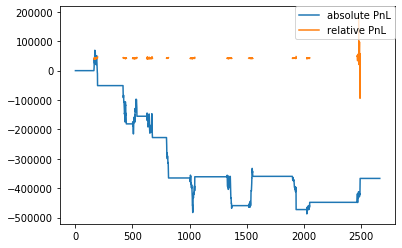

In [22]:
np.savetxt("absolute_PnL1.csv",np.array(abs_PnL1),fmt='%1s',delimiter=',')
np.savetxt("relative_PnL1.csv",np.array(rel_PnL1),fmt='%1s',delimiter=',')
x_axis = [i for i in range(len(AdjPrice[:,0])-N)]
plt.plot(x_axis,abs_PnL1,label="absolute PnL")
plt.plot(x_axis,rel_PnL1,label="relative PnL")

plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)

plt.show()

In [ ]:
## Change the transaction cost above into 0 for test

In [23]:
#1(b) invest with C_bar*V
lambda2b = np.zeros((d,d)) #lam2* for pair i,j
ifopenb = np.zeros((d,d)) #if open the position
iflongb = np.zeros((d,d)) #if long the pair
P_matrixb = np.zeros((d,d)) #for computing shares
c_matrixb = np.zeros((d,d)) #coeff matrix for pair i,j
V_matrix = np.zeros((d,d)) #opt result for obj function
mean_matrixb = np.zeros((d,d)) #mean of process for pairs
sigma_tilde_matrixb = np.zeros((d,d)) #for stop-loss mech
open_time_matrixb = np.zeros((d,d)) #for stop-loss mech
port1b = np.zeros((len(AdjPrice[:,0]),d)) #num of shares with time and asset

pbar = ProgressBar().start()
for k in range(len(AdjPrice[:,0])-N):
    pbar.update(int((k/(len(AdjPrice[:,0])-N-1))*100))
    time.sleep(0.01)
#we are standing at day k+N actually
    port1b[k+N,:] = port1b[k+N-1,:]
    for i in range(d):
        for j in range(i+1,d):
            
            #not open, tell if should open
            if ifopen[i,j] == 0:
                Calibri_Pri_i = AdjPrice[k:k+N,i]
                Calibri_Pri_j = AdjPrice[k:k+N,j]
                
                #regression
                my_arima = arima_model.ARMA(Calibri_Pri_i,[1,0],Calibri_Pri_j)
                arma_results = my_arima.fit()
                c_ij = arma_results.params[1]
                
                #construct the pair
                Z = np.array(Calibri_Pri_i)-np.array(Calibri_Pri_j)*c_ij
                mean_Z = np.mean(Z)
                Z = Z-np.mean(Z)
                
                #run DF test
                my_DF = stattools.adfuller(Z,1,'c',None)
                
                #if cointegrated, open position
                if my_DF[1] <= p_star:
                    ifopenb[i,j] = 1
                    open_time_matrixb[i,j] = k+N
                    c_matrixb[i,j] = c_ij
                    mean_matrixb[i,j] = mean_Z
                    phi, sigma = linear_model.yule_walker(Z, order=1)
                    rho = 1-phi[0]
                    
                    sigma_tilde = sigma/((1-phi[0]**2)**0.5)
                    sigma_tilde_matrixb[i,j] = sigma_tilde
                    
                    lambda1 = AdjPrice[k+N,i]-AdjPrice[k+N,j]*c_ij-mean_Z
                    P = AdjPrice[k+N,i]
                    P_matrixb[i,j] = P
                    c = P*4*T_lam
                    
                    if lambda1 <= 0:
                        iflongb[i,j] = 1
                        obj = lambda lam: -(lam-lambda1-c)*(T-expd_tau([lambda1,lam],rho,sigma))/P
                        cons = ({'type': 'ineq', 'fun': lambda lmbd: lmbd-lambda1-c},
                               {'type': 'ineq', 'fun': lambda lmbd: T-expd_tau([lambda1,lmbd],rho,sigma)}) # inequality means that it is to be non-negative
                        lmbd0 = lambda1/2
                        opt = scipy.optimize.minimize(obj,lmbd0,constraints=cons)
                        lambda2b[i,j] = opt.x[0]
                        V = -obj(opt.x[0])
                        V_matrix[i,j] = V
                        port1b[k+N,i] += C_bar / P
                        port1b[k+N,j] += C_bar / P * (-c_ij)
                    else:
                        iflongb[i,j] = 0
                        obj = lambda lam: -(lambda1-lam-c)*(T-expd_tau([-lambda1,-lam],rho,sigma))/P
                        cons = ({'type': 'ineq', 'fun': lambda lmbd: lambda1-lmbd-c},
                               {'type': 'ineq', 'fun': lambda lmbd: T-expd_tau([-lambda1,-lmbd],rho,sigma)}) # inequality means that it is to be non-negative
                        lmbd0 = lambda1/2
                        opt = scipy.optimize.minimize(obj,lmbd0,constraints=cons)
                        lambda2b[i,j] = opt.x[0]
                        V = -obj(opt.x[0])
                        V_matrix[i,j] = V
                        port1b[k+N,i] += -C_bar / P
                        port1b[k+N,j] += C_bar / P * c_ij
                        
            #already open, tell if close            
            elif ifopenb[i,j] == 1:
                #tell if we should close
                if iflongb[i,j] == 1:
                    if AdjPrice[k+N,i]-c_matrixb[i,j]*AdjPrice[k+N,j]-mean_matrixb[i,j] >= lambda2b[i,j] or AdjPrice[k+N,i]-c_matrixb[i,j]*AdjPrice[k+N,j]-mean_matrixb[i,j] <= -lambda_bar*sigma_tilde_matrixb[i,j] or k + N - open_time_matrixb[i,j] > T_bar:
                        ifopenb[i,j] = 0
                        port1b[k+N,i] -= C_bar*V_matrix[i,j] / P_matrixb[i,j]
                        port1b[k+N,j] -= C_bar*V_matrix[i,j] / P_matrixb[i,j] * (-c_matrixb[i,j])
                        
                elif iflongb[i,j] == 0:
                    if AdjPrice[k+N,i]-c_matrixb[i,j]*AdjPrice[k+N,j]-mean_matrixb[i,j] <= lambda2b[i,j] or AdjPrice[k+N,i]-c_matrixb[i,j]*AdjPrice[k+N,j]-mean_matrixb[i,j] >= lambda_bar*sigma_tilde_matrixb[i,j] or k + N - open_time_matrixb[i,j] > T_bar:
                        ifopenb[i,j] = 0
                        port1b[k+N,i] -= -C_bar*V_matrix[i,j] / P_matrixb[i,j]
                        port1b[k+N,j] -= C_bar*V_matrix[i,j] / P_matrixb[i,j] * c_matrixb[i,j]

pbar.finish()

100% |########################################################################|


In [24]:
#1(b) continue
#compute total long and short
Total_Amountb = np.multiply(port1b,AdjPrice[:,:d])
L1b = np.sum((Total_Amountb>0)*Total_Amountb,axis=1)
S1b = -np.sum((Total_Amountb<0)*Total_Amountb,axis=1)

#compute absolute PnL process
abs_PnL1b = []
for i in range(d):
    temp = []
    for k in range(len(AdjPrice[:,0])-N):
        if k == 0:
            temp.append(AdjPrice[k+N-1,i])
        else:
            temp.append(temp[-1]+port1b[k+N-1,i]*(AdjPrice[k+N,i]-AdjPrice[k+N-1,i])-np.abs(port1b[k+N-1,i]-port1b[k+N-2,i])*AdjPrice[k+N-1,i]*T_lam)
    
    abs_PnL1b.append(temp)
    
abs_PnL1b = np.sum(abs_PnL1b, axis=0)
abs_PnL1b =  np.array(abs_PnL1b)

#compute relative PnL process
rel_PnL1b = []
for k in range(len(AdjPrice[:,0])-N):
    if k == 0:
        rel_PnL1b.append(1)
    else:
        rel_PnL1b.append(temp[-1]*(1+(abs_PnL1b[k]-abs_PnL1b[k-1])/(L1b[k+N-1]-S1b[k+N-1])))
    
rel_PnL1b = np.array(rel_PnL1b)

#sharpe ratio for absolute PnL
print("Sharpe Ratio for absolute PnL is:", np.mean(np.diff(abs_PnL1b)) / np.sqrt(np.var(np.diff(abs_PnL1b))))

#sharpe ratio for relative PnL
print("Sharpe Ratio for relative PnL is:", np.mean(np.diff(rel_PnL1b) / rel_PnL1b[:-1]) / np.sqrt(np.var(np.diff(abs_PnL1b) / rel_PnL1b[:-1])))

Sharpe Ratio for absolute PnL is: -0.018348849866976644
Sharpe Ratio for relative PnL is: nan


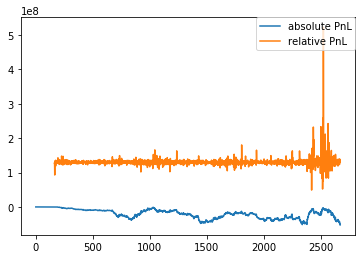

In [26]:
np.savetxt("absolute_PnL1b.csv",np.array(abs_PnL1b),fmt='%1s',delimiter=',')
np.savetxt("relative_PnL1b.csv",np.array(rel_PnL1b),fmt='%1s',delimiter=',')
x_axis = [i for i in range(len(AdjPrice[:,0])-N)]
plt.plot(x_axis,abs_PnL1b,label="absolute PnL")
plt.plot(x_axis,rel_PnL1b,label="relative PnL")

plt.legend(bbox_to_anchor=(1.0,1), loc=1, borderaxespad=0.)

plt.show()

In [31]:
#2 adding new settings
C_hat = 50000000 #total size of investment on the long side of the pairs
gamma = 1
d = 5

In [32]:
A = np.zeros((d,d))
temp = 0
for i in range(d):
    for j in range(d):
        if i < j:
            A[i,j] = temp
            temp += 1

In [33]:
def return_pair(x):
    return np.argwhere(A == x)

In [34]:
#2 continue
log_price = np.log(AdjPrice)

port2 = np.zeros((len(log_price[:,0]),d)) #num of shares with time and asset

pbar = ProgressBar().start()
for k in range(len(log_price[:,0])-N):
    pbar.update(int((k/(len(AdjPrice[:,0])-N-1))*100))
    time.sleep(0.01)
#we are standing at day k+N actually
    ifopen2 = np.zeros(int(d*(d-1)/2))
    c_matrix2 = np.zeros(int(d*(d-1)/2))
    res_matrix = np.zeros((N-1,int(d*(d-1)/2)))
    mu_matrix = np.zeros(int(d*(d-1)/2))
    for i in range(d):
        for j in range(i+1,d):
            
            #don't care if already open, just check if cointegrated
            Calibri_Pri_i = log_price[k:k+N,i]
            Calibri_Pri_j = log_price[k:k+N,j]
                
            #regression
            my_arima = arima_model.ARMA(Calibri_Pri_i,[1,0],Calibri_Pri_j)
            arma_results = my_arima.fit()
            c_ij = arma_results.params[1]
            c_matrix2[int(A[i,j])] = c_ij
                
            #construct the pair
            Z = np.array(Calibri_Pri_i)-np.array(Calibri_Pri_j)*c_ij
            mean_Z = np.mean(Z)
                
            #run DF test
            my_DF = stattools.adfuller(Z,1,'c',None)
                
            #if cointegrated, save pairs
            if my_DF[1] <= p_star:
                ifopen2[int(A[i,j])] = 1
                phi, sigma = linear_model.yule_walker(Z, order=1)
                rho = 1-phi[0]
                
                #compute mu and cov matrix
                res = []
                for t in range(len(Z)-1):
                    res.append(Z[t+1]-Z[t]*phi[0])
                res_matrix[:,int(A[i,j])] = res
                mu_matrix[int(A[i,j])] = -rho*(Z[-1]-mean_Z)
    
    #now we have save all cointegrated pairs, compute strategy
    trading_inx = []
    for inx in range(int(d*(d-1)/2)):
        if ifopen2[inx] == 1:
            trading_inx.append(inx)
#     print(trading_inx)
    #getting cov matrix
    cov_matrix = np.cov(res_matrix.T)
    
    if trading_inx:
        def kappa(i,j,l):
            if l==i:
                return 1
            elif l==j:
                return -c_matrix2[int(A[i,j])]
            else:
                return 0
            
        def my_obj(x):
            term1 = np.dot(x[trading_inx].T,mu_matrix[trading_inx])
            
            term2 = 0
            for l in range(d):
                temp = 0
                for ij in trading_inx:
                    temp += kappa(return_pair(ij)[0][0],return_pair(ij)[0][1],l) * x[ij]
                temp -= port2[k+N-1,l]*AdjPrice[k+N,l]
                temp = np.abs(temp)
                term2 += temp
            term2 *= T_lam
#             print(term2)
            
            term3 = 0
            for ij in trading_inx:
                for ij_prime in trading_inx:
                    term3 += cov_matrix[ij,ij_prime]*x[ij]*x[ij_prime]
            term3 = np.sqrt(term3)*gamma
#             print(term3)
            
            return term1 - term2 - term3
        
        def my_constr1(x):
            return np.sum(np.abs(x[trading_inx])) - C_hat
#         def my_constr2(x):
#             for ij in trading_inx:
#                 x[ij] -= x[ij]
#             return np.sum(np.abs(x))
        
#         constr = ({'type': 'eq', 'fun': my_constr1},{'type': 'eq', 'fun': my_constr2})
        constr = {'type': 'eq', 'fun': my_constr1}
        
        x0 = np.zeros(int(d*(d-1)/2)); x0[trading_inx][0] = C_hat
        opt2 = scipy.optimize.minimize(my_obj, x0, constraints=constr, options={'maxiter':1e6})
#         print(opt2.x)
        
        for ij in trading_inx:
            port2[k+N,return_pair(ij)[0][0]] += opt2.x[ij]
            port2[k+N,return_pair(ij)[0][1]] += opt2.x[ij]*(-c_matrix2[ij])
pbar.finish()

100% |########################################################################|


In [35]:
#2 continue
#compute total long and short
Total_Amount2 = np.multiply(port2,AdjPrice[:,:d])
L2 = np.sum((Total_Amount2>0)*Total_Amount2,axis=1)
S2 = -np.sum((Total_Amount2<0)*Total_Amount2,axis=1)

#compute absolute PnL process
abs_PnL2 = []
for i in range(d):
    temp = []
    for k in range(len(log_price[:,0])-N):
        if k == 0:
            temp.append(AdjPrice[k+N-1,i])
        else:
            temp.append(temp[-1]+port2[k+N-1,i]*(AdjPrice[k+N,i]-AdjPrice[k+N-1,i])-np.abs(port2[k+N-1,i]-port2[k+N-2,i])*AdjPrice[k+N-1,i]*T_lam)
    
    abs_PnL2.append(temp)
    
abs_PnL2 = np.sum(abs_PnL2, axis=0)
abs_PnL2 = np.array(abs_PnL2)

#compute relative PnL process
rel_PnL2 = []
for k in range(len(log_price[:,0])-N):
    if k == 0:
        rel_PnL2.append(1)
    else:
        rel_PnL2.append(rel_PnL2[-1]*(1+(abs_PnL2[k]-abs_PnL2[k-1])/(L2[k+N-1]-S2[k+N-1])))
    
rel_PnL2 = np.array(rel_PnL2)


#sharpe ratio for absolute PnL
print("Sharpe Ratio for absolute PnL is:", np.mean(np.diff(abs_PnL2)) / np.sqrt(np.var(np.diff(abs_PnL2))))

#sharpe ratio for relative PnL
print("Sharpe Ratio for relative PnL is:", np.mean(np.diff(rel_PnL2) / rel_PnL2[:-1]) / np.sqrt(np.var(np.diff(abs_PnL2) / rel_PnL2[:-1])))

Sharpe Ratio for absolute PnL is: 0.060693118141089165
Sharpe Ratio for relative PnL is: nan


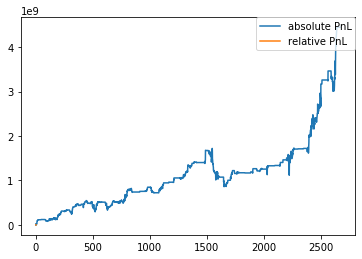

In [39]:
np.savetxt("absolute_PnL2.csv",np.array(abs_PnL2),fmt='%1s',delimiter=',')
np.savetxt("relative_PnL2.csv",np.array(rel_PnL2),fmt='%1s',delimiter=',')
x_axis = [i for i in range(len(AdjPrice[:,0])-N)]
plt.plot(x_axis,abs_PnL2,label="absolute PnL")
plt.plot(x_axis,rel_PnL2,label="relative PnL")

plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)

plt.show()